In [2]:
from ultralytics import YOLO
import random
import matplotlib.pyplot as plt
import cv2 as cv
import os
import numpy as np
from dotenv import load_dotenv

load_dotenv()

True

In [32]:
model_version = "train3"
number_test_images = 10

In [33]:
def extract_bounding_box_from_data_set(img_name):

    img_width = 1024
    img_height = 128

    with open(os.path.join(PATH_val + '/labels', img_name).replace('.jpg', '.txt'), 'r') as file:
        contents = file.read()
    contents = contents.strip().split('\n')

    # Extract bounding box coordinates without the class label
    bounding_boxes = []
    for line in contents:
        parts = line.split()  # Split the line into parts
        coords = list(map(float, parts[1:]))  # Skip the first element (class label) and convert the rest to float
        
        # Convert YOLO percentages to real coordinates
        x_center = coords[0] * img_width
        y_center = coords[1] * img_height
        width = coords[2] * img_width
        height = coords[3] * img_height

        # Calculate real bounding box coordinates
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # Append as [x_min, y_min, x_max, y_max]
        bounding_boxes.append([x_min, y_min, x_max, y_max])
    bounding_boxes_array = np.array(bounding_boxes).astype(int)

    return bounding_boxes_array

print(os.getcwd())

PATH_train = os.getenv('PATH_TO_TRAIN_DATA')
PATH_val = os.getenv('PATH_TO_VAL_DATA')

assert os.path.exists(PATH_train), 'PATH_TO_TRAIN_DATA is not valid'
assert os.path.exists(PATH_val), 'PATH_TO_VAL_DATA is not valid'

model = YOLO(f'../runs/detect/{model_version}/weights/best.pt')
sample_images = random.sample(os.listdir(PATH_val + '/images'), number_test_images)

/cluster/home/tristanw/tdt17-mini-project/model



image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_313_png.rf.17e22e38b658f4da17ea2fdd93ccaa35.jpg: 96x640 (no detections), 339.2ms
Speed: 0.7ms preprocess, 339.2ms inference, 0.4ms postprocess per image at shape (1, 3, 96, 640)

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_1043_png.rf.aa42cbe5a33c37340f8ef37639d54482.jpg: 96x640 2 poles, 22.1ms
Speed: 0.6ms preprocess, 22.1ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_1272_png.rf.56ffd419fa5ff223d6d77bf95c25cc0d.jpg: 96x640 1 pole, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.7ms postprocess per image at shape (1, 3, 96, 640)

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_2079_png.rf.93f860dc0d6a49c341df6563c1d9eefc.jpg: 96x640 2 poles, 22.3ms
Speed: 0.6ms preprocess, 22.3ms inference, 0.7ms postprocess per image at shape (1, 3, 96, 640)

ima

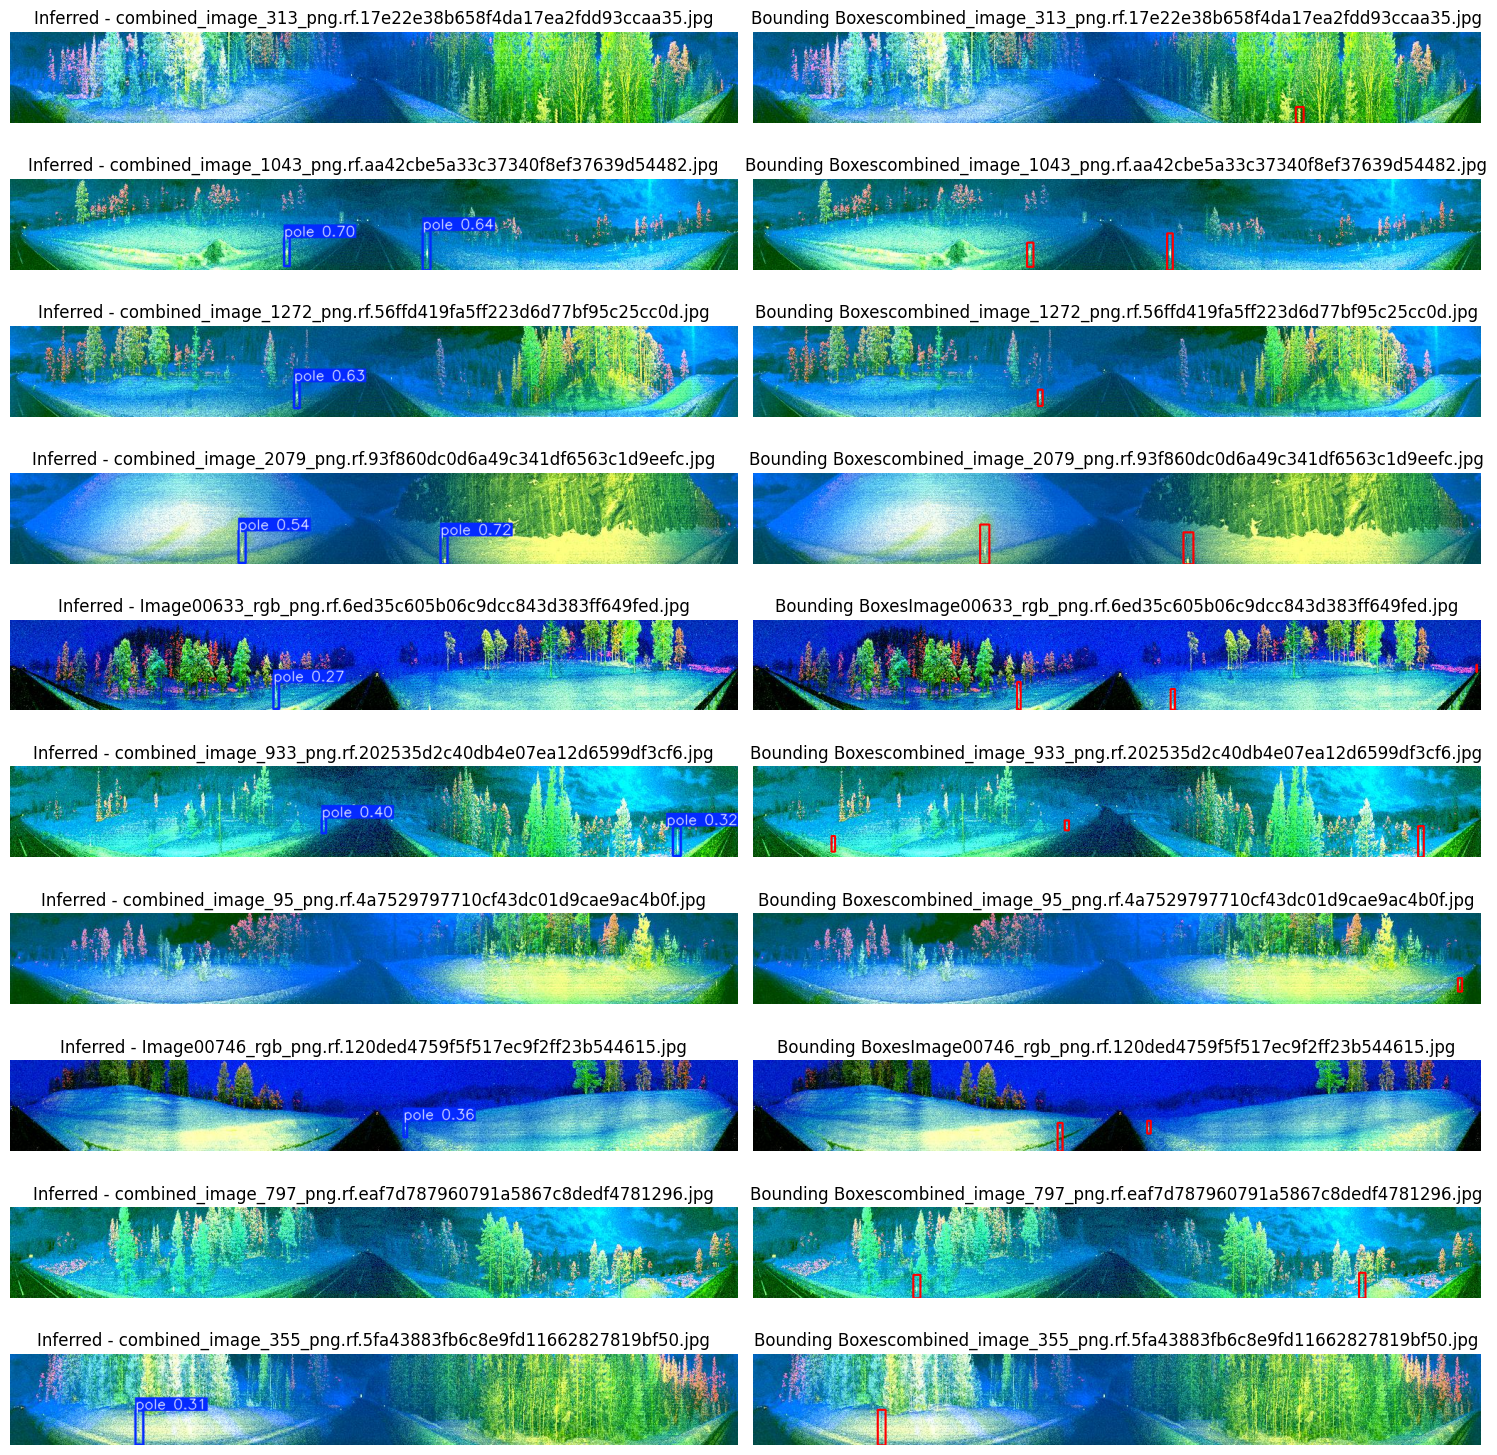

In [34]:
fig, axes = plt.subplots(len(sample_images), 2, figsize=(15, 1.5 * len(sample_images)))

for i, img_name in enumerate(sample_images):
    # Plot 1: Inferred results
    results = model(os.path.join(PATH_val + '/images', img_name), device='cpu')
    infered = results[0].plot()
    infered = cv.cvtColor(infered, cv.COLOR_BGR2RGB)
    axes[i, 0].imshow(infered)
    axes[i, 0].set_title(f"Inferred - " + img_name)
    axes[i, 0].axis("off")

    # Plot 2: Bounding box annotations
    img = cv.imread(os.path.join(PATH_val + '/images', img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    bounding_boxes = extract_bounding_box_from_data_set(img_name)
    if len(bounding_boxes) > 0:
        for box in bounding_boxes:
            img = cv.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    axes[i, 1].imshow(img)
    axes[i, 1].set_title(f"Bounding Boxes" + img_name)
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()